In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps


import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F




In [3]:
# Display images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.xlabel("Epochs")
    plt.ylabel("Contrastive Loss")
    plt.title("Training Loss Curve")
    plt.show()

In [4]:
# Setting up Dataset
class SiameseNetworkDataset(Dataset):
    def __init__(self,image_folder,transform=None):
        self.image_folder = image_folder    
        self.transform = transform
        
    def __getitem__(self,index):
        image_0_tuple = random.choice(self.image_folder.imgs)

        same_class = random.randint(0,1) 
        if same_class:
            while True:
                image_1_tuple = random.choice(self.image_folder.imgs) 
                if image_0_tuple[1] == image_1_tuple[1]:
                    break
        else:

            while True:
                image_1_tuple = random.choice(self.image_folder.imgs) 
                if image_0_tuple[1] != image_1_tuple[1]:
                    break

        img0 = Image.open(image_0_tuple[0])
        img1 = Image.open(image_1_tuple[0])

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(image_1_tuple[1] != image_0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.image_folder.imgs)

Download the dataset from our [GitHub](https://github.com/maticvl/dataHacker/blob/master/DATA/at%26t.zip) profile, just by running the code below.

In [5]:
# Load the training dataset
folder_dataset = datasets.ImageFolder(root="/content/drive/MyDrive/LFW_dataset/Training")

In [6]:
# Transforming function
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

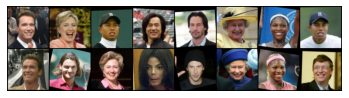

[0. 1. 1. 1. 0. 0. 0. 1.]


In [7]:
# Same pair means 0, different pair means 1
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

example_batch = next(iter(vis_dataloader))

joined = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(joined))
print(example_batch[2].numpy().reshape(-1))

In [8]:
from torch.nn.modules.dropout import Dropout2d
#Create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_func(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_func(input1)
        output2 = self.forward_func(input2)

        return output1, output2

In [9]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [10]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(100):

    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        optimizer.zero_grad()

        output1, output2 = net(img0, img1)

        loss_contrastive = criterion(output1, output2, label)

        loss_contrastive.backward()

        optimizer.step()

        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

In [ ]:

folder_dataset_test = datasets.ImageFolder(root="/content/drive/MyDrive/LFW_dataset/Testing")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):

    _, x1, label2 = next(dataiter)

    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

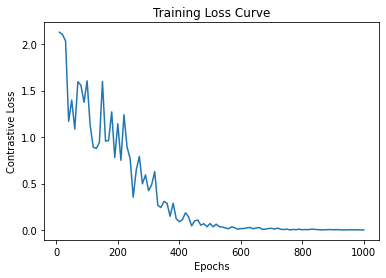

In [ ]:
show_plot(counter, loss_history)

In [17]:
test_model = SiameseNetwork().cuda()

checkpoint = torch.load("/content/drive/MyDrive/LFW_dataset/model.pt")
test_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

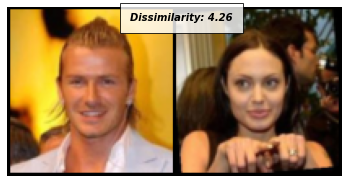

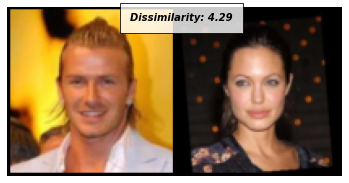

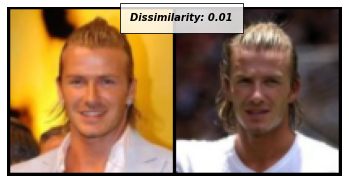

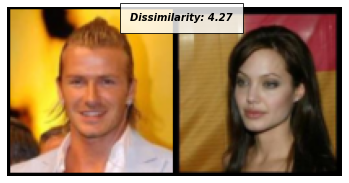

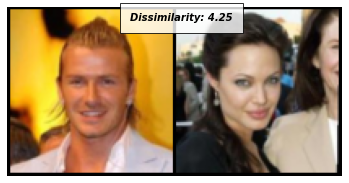

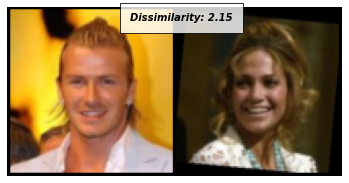

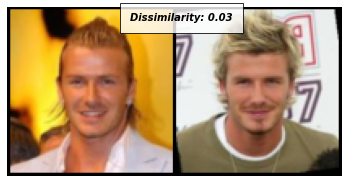

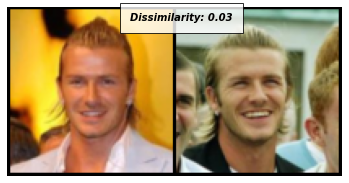

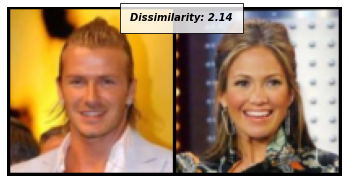

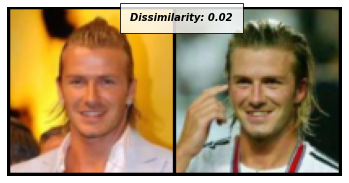

In [13]:

folder_dataset_test = datasets.ImageFolder(root="/content/drive/MyDrive/LFW_dataset/Testing")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):

    _, x1, label2 = next(dataiter)
    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = test_model(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')


In [ ]:
threshold = 1.00
total_images_test = 30
comparison = 0
with torch.no_grad():
  for i, (img0, img1, label) in enumerate(test_dataloader, 0):

    img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
    output1, output2 = test_model(img0, img1)
    euclidean_distance = F.pairwise_distance(output1, output2)
    sample_pred = torch.where(euclidean_distance <= threshold, 0, 1)
    comparison += torch.abs(sample_pred - label).sum()
    print('comparison ', comparison.item())
    print(f'sample_pred: {sample_pred.item()}, label: {label.item()} ')

accuracy = (len(test_dataloader.dataset) - comparison)/len(test_dataloader.dataset)
paircount = len(test_dataloader.dataset)
print('Accuracy: ', accuracy.item())
print('Pair Count: ', paircount)
